## Multivariate LSTM

# Import packages

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

from pandas_datareader import data as wb
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

# Set figure parameters
plt.rcParams['figure.figsize'] = [10, 7.5]


# Input data

## FX

In [2]:
yf.pdr_override()

data = wb.get_data_yahoo('VND=x', start = '2023-03-01', end = '2024-12-31', interval = '1mo')

# Obtain latest vnd to usd rate
df_conv = wb.get_data_yahoo('VND=x', start = '2023-03-01', end = '2024-12-31')
data1 = 1/df_conv
vnd_to_usd = data1.iloc[-1,0]

# Clean up statistics 
df = pd.DataFrame(data['Adj Close'])
df.rename(columns = {'Adj Close':'USDVND'}, inplace = True)

# change the datetime format
usdvnd_up = pd.DataFrame(df['USDVND'].resample('YS').mean())
usdvnd_up.index = pd.to_datetime(usdvnd_up.index, format = '%Y')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## CSV data

C:\Users\User\AppData\Local\Temp\ipykernel_13912\2964939829.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ivdata = pd.read_csv(filepath, parse_dates=['Date'])


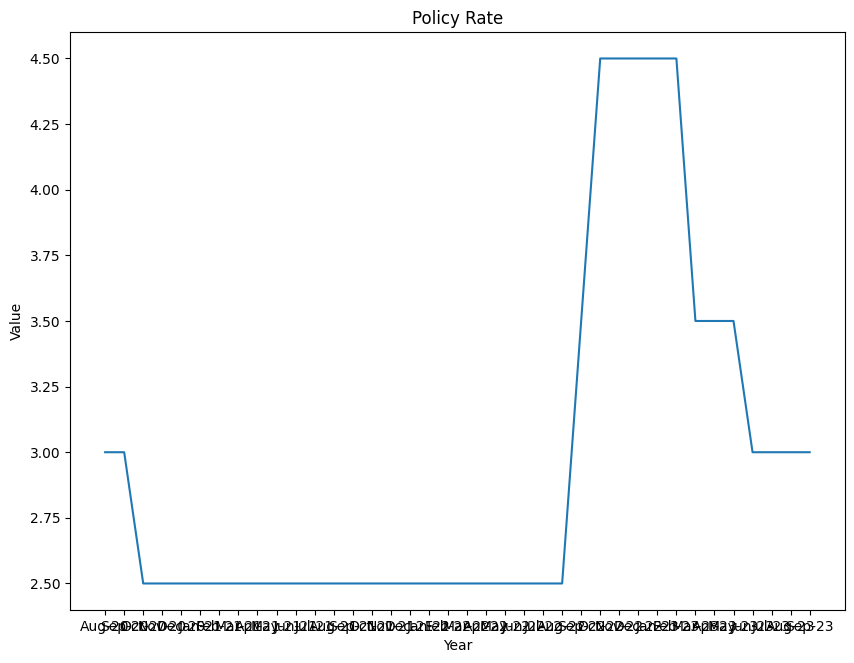

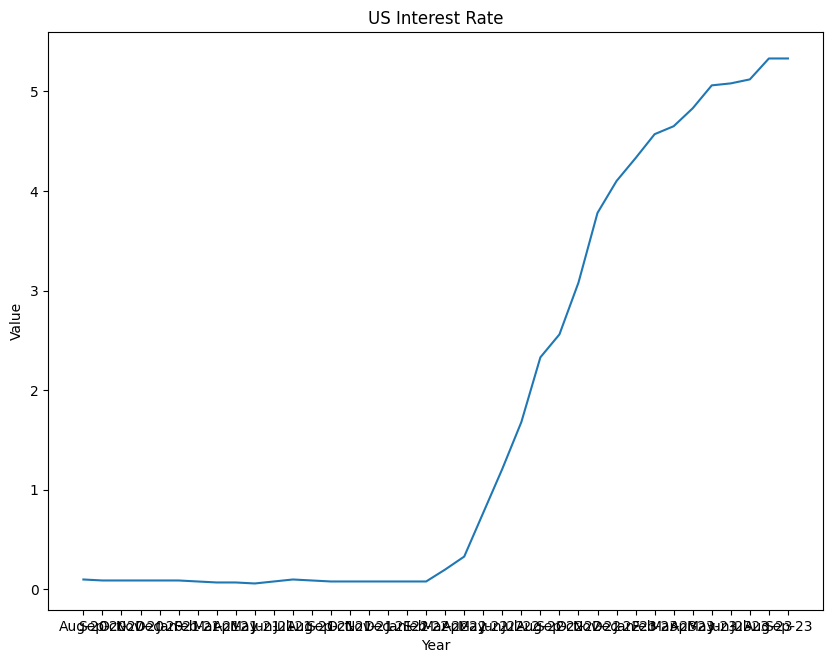

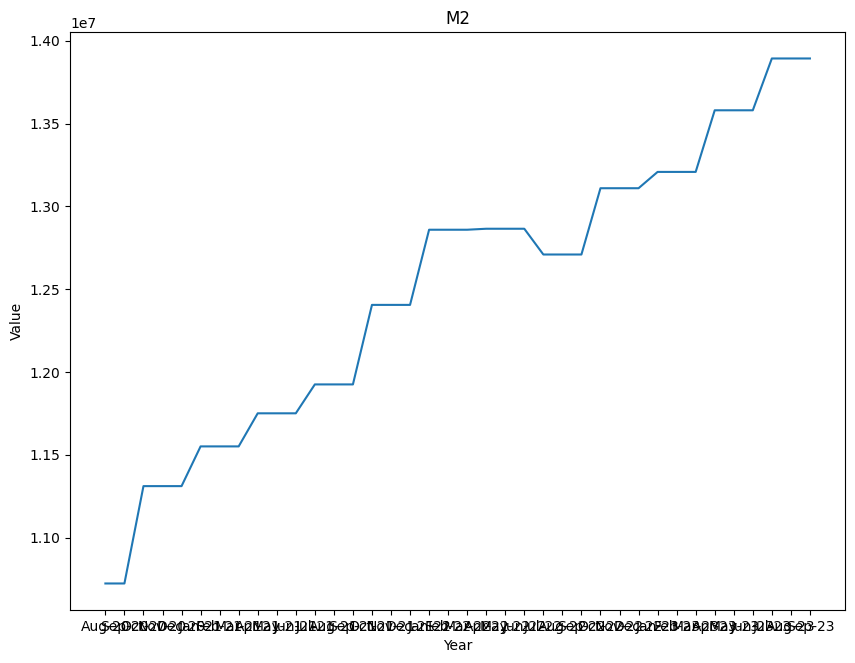

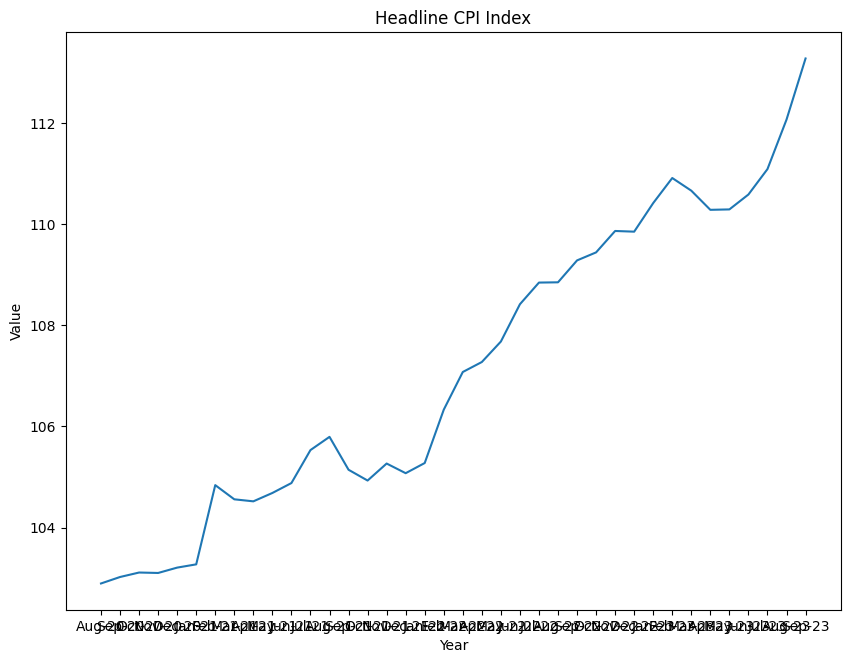

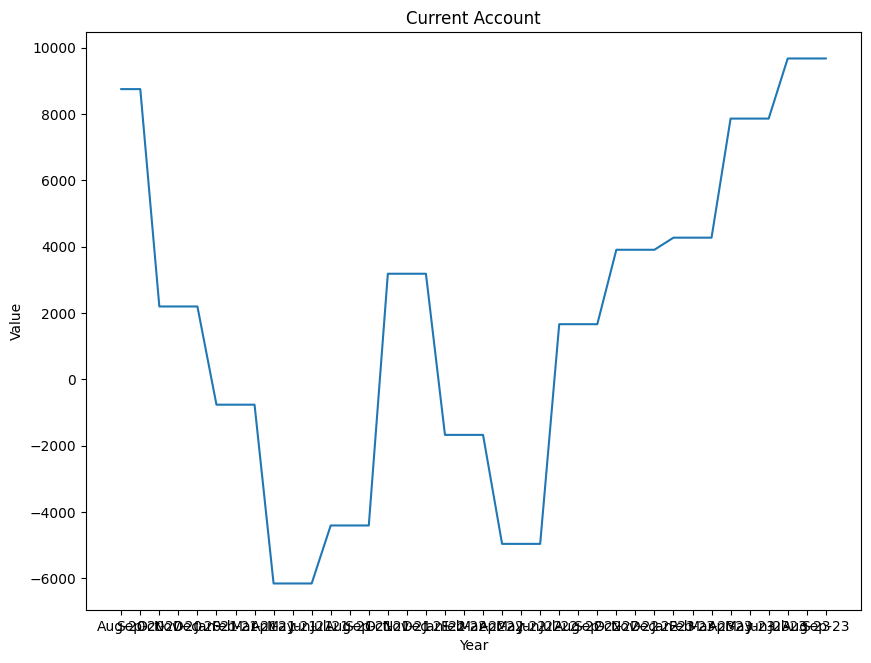

In [21]:
# Filepath to the CSV file
filepath = r"C:\Users\User\Desktop\CompiledData.csv"

# Read the CSV file, specifying the date format
ivdata = pd.read_csv(filepath, parse_dates=['Date'])

# Set the 'Date' column as the index
ivdata.set_index('Date', inplace=True)

# Retaining only wanted data
ivdata = ivdata[['Policy Rate', 'US Interest Rate', 'M2', 'Headline CPI Index', 'Current Account']]

# Drop rows with NaN values
ivdata.dropna(inplace=True)

# Plot each numeric column
for column in ivdata.select_dtypes(include=['float64', 'int64']).columns:
    plt.plot(ivdata.index, ivdata[column])
    plt.title(column)
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.show()

ivdata.index = pd.to_datetime(ivdata.index, format='%b-%y')
fulldataset = pd.concat([df, ivdata], axis=0)
fulldataset = fulldataset.sort_index()
fulldataset.columns = ['FX Data'] + list(fulldataset.columns[1:])
fulldataset['FX Data'] = fulldataset['FX Data'].ffill()
fulldataset = fulldataset.dropna()

# Prepare data

In [22]:
dataset = fulldataset.values
dataset = dataset.astype('float32')

array([[2.3470000e+04, 3.5000000e+00, 4.8299999e+00, 1.3580271e+07,
        1.1028704e+02, 7.8600000e+03],
       [2.3445000e+04, 3.5000000e+00, 5.0599999e+00, 1.3580271e+07,
        1.1029531e+02, 7.8600000e+03],
       [2.3480000e+04, 3.0000000e+00, 5.0799999e+00, 1.3580271e+07,
        1.1059024e+02, 7.8600000e+03],
       [2.3685000e+04, 3.0000000e+00, 5.1199999e+00, 1.3893209e+07,
        1.1109321e+02, 9.6730000e+03],
       [2.4110000e+04, 3.0000000e+00, 5.3299999e+00, 1.3893209e+07,
        1.1207205e+02, 9.6730000e+03],
       [2.4110000e+04, 3.0000000e+00, 5.3299999e+00, 1.3893209e+07,
        1.1328232e+02, 9.6730000e+03]], dtype=float32)

In [23]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# separate into train and test data
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [24]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back = 3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [28]:
# reshape input to be [samples, time steps, features]
n = 6 # number of columns
trainX = np.reshape(trainX, (trainX.shape[0], look_back, n))
testX = np.reshape(testX, (testX.shape[0], look_back, n))

# Build model

In [26]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(64, input_shape=(look_back, n)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=300, batch_size=16, verbose=1)

# Save the trained model
model.save('trained_lstm_model.h5')

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = np.squeeze(trainPredict)
testPredict = np.squeeze(testPredict)

Epoch 1/300


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\anaconda3\envs\tensorflow_env\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


ValueError: math domain error

In [ ]:
# Transform data
def inverse_transform(arr):
    extended = np.zeros((len(arr), n))
    extended[:, 0] = arr
    return scaler.inverse_transform(extended)[:, 0]


trainPredict = inverse_transform(trainPredict)
testPredict = inverse_transform(testPredict)
trainY = inverse_transform(trainY)
testY = inverse_transform(testY)

In [ ]:
# shift predictions up by one
testPredict = np.delete(testPredict, -1)
testY = np.delete(testY, 0)

to_row = len(fulldataset) - len(testY)
date_range = fulldataset[to_row:].index
plt.plot(date_range, testPredict, color = 'blue', marker = 'o', linestyle = 'dashed', label = 'Predicted')
plt.plot(date_range, testY, color = 'red', label = 'Actual')
plt.legend()
plt.show()

testScore = np.sqrt(mean_squared_error(testY, testPredict))
testScore = testScore*vnd_to_usd

print('Test Score: %.6f RMSE' % (testScore))

rmspe = (np.sqrt(np.mean(np.square(np.subtract(testY ,testPredict) / df_test)))) * 100
print('Test Score: %.6f RMSPE' % (rmspe))

# Forecast 

In [ ]:
from tensorflow.keras.models import load_model

def generate_forecasts(model_path, test_data, forecast_steps):
    """
    Generate forecasts beyond the test data using a trained LSTM model.
    
    Args:
    - model_path: Path to the trained LSTM model file.
    - test_data: Test data used for model evaluation.
    - forecast_steps: Number of future time steps to forecast.
    
    Returns:
    - forecasts: Array containing the forecasted values.
    """
    # Load the trained LSTM model
    model = load_model(model_path)
    
    # Prepare the test data for forecasting
    current_data = np.copy(test_data)
    
    # Generate forecasts
    forecasts = []
    for _ in range(forecast_steps):
        # Predict the next time step
        next_step_prediction = model.predict(current_data.reshape(1, *current_data.shape))
        
        # Append the prediction to the forecasts
        forecasts.append(next_step_prediction[0, 0])
        
        # Update current data by removing the oldest time step and appending the latest prediction
        current_data = np.roll(current_data, -1)
        current_data[-1] = next_step_prediction
    
    return np.array(forecasts)

# Example usage:
# Replace 'trained_lstm_model.h5' with the path to your trained LSTM model file
# Replace 'test_data' with your actual test data
# Replace 'forecast_steps' with the number of future time steps to forecast
# forecasts = generate_forecasts('trained_lstm_model.h5', test_data, forecast_steps)


In [ ]:
test_data = testX[-1]
forecast_steps = 6

In [ ]:
forecasts = generate_forecasts('trained_lstm_model.h5', test_data, forecast_steps)

In [ ]:
forecasts = np.squeeze(forecasts)

# Transform data
def inverse_transform(arr):
    extended = np.zeros((len(arr), n))
    extended[:, 0] = arr
    return scaler.inverse_transform(extended)[:, 0]

forecasts = inverse_transform(forecasts)
forecasts = np.insert(forecasts, 0, testPredict[-1])

In [ ]:
from pandas.tseries.offsets import DateOffset
future_dates = [fulldataset.index[-1] + DateOffset(months = x) for x in range (0,forecast_steps+1)]
future_dates_df = pd.DataFrame(index = future_dates[0:], columns = df.columns)

In [ ]:
plt.plot(date_range, testPredict, color = 'blue', marker = 'o', linestyle = 'dashed', label = 'Validation')
plt.plot(future_dates_df.index, forecasts, color = 'green', marker = 'o', linestyle = 'dashed', label = 'Forecast')
plt.plot(data['Adj Close'], color ='red', label = 'Actual')
plt.legend()

In [10]:
fulldataset

,FX Data,Policy Rate,US Interest Rate,M2,Headline CPI Index,Current Account
Date,,,,,,
2023-04-01,23470.0,3.5,4.83,13580270.82,110.287041,7860.0
2023-05-01,23445.0,3.5,5.06,13580270.82,110.295312,7860.0
2023-06-01,23480.0,3.0,5.08,13580270.82,110.590242,7860.0
2023-07-01,23685.0,3.0,5.12,13893209.25,111.093206,9673.0
2023-08-01,24110.0,3.0,5.33,13893209.25,112.072049,9673.0
2023-09-01,24110.0,3.0,5.33,13893209.25,113.282315,9673.0
